In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from geoloader import *

## Create a dataframe with labels

In [3]:
city_imgs = AerialCity('atlanta')
df, n_matches = city_imgs.create_df()
df.head()

['all_sat_LLAHTR', 'all_uav_LLAHTR', 'all_uav_xyzHTR', 'match_array_40', 'sat300_image_paths', 'uav_image_paths']


,uav,sat,label,is_valid
0,train/atlanta/atlanta_uav/uav/uav0.png,train/atlanta/atlanta_sat/sat300/sat0.png,1,False
1,train/atlanta/atlanta_uav/uav/uav0.png,train/atlanta/atlanta_sat/sat300/sat10.png,1,False
2,train/atlanta/atlanta_uav/uav/uav0.png,train/atlanta/atlanta_sat/sat300/sat15.png,1,False
3,train/atlanta/atlanta_uav/uav/uav1.png,train/atlanta/atlanta_sat/sat300/sat1.png,1,False
4,train/atlanta/atlanta_uav/uav/uav1.png,train/atlanta/atlanta_sat/sat300/sat28.png,1,False


In [4]:
df[n_matches-5:n_matches+5]

,uav,sat,label,is_valid
3891,train/atlanta/atlanta_uav/uav/uav2074.png,train/atlanta/atlanta_sat/sat300/sat2074.png,1,True
3892,train/atlanta/atlanta_uav/uav/uav2075.png,train/atlanta/atlanta_sat/sat300/sat2034.png,1,True
3893,train/atlanta/atlanta_uav/uav/uav2075.png,train/atlanta/atlanta_sat/sat300/sat2075.png,1,True
3894,train/atlanta/atlanta_uav/uav/uav2076.png,train/atlanta/atlanta_sat/sat300/sat2076.png,1,True
3895,train/atlanta/atlanta_uav/uav/uav2077.png,train/atlanta/atlanta_sat/sat300/sat2077.png,1,True
3896,train/atlanta/atlanta_uav/uav/uav0.png,train/atlanta/atlanta_sat/sat300/sat1073.png,0,False
3897,train/atlanta/atlanta_uav/uav/uav0.png,train/atlanta/atlanta_sat/sat300/sat754.png,0,False
3898,train/atlanta/atlanta_uav/uav/uav0.png,train/atlanta/atlanta_sat/sat300/sat1506.png,0,False
3899,train/atlanta/atlanta_uav/uav/uav1.png,train/atlanta/atlanta_sat/sat300/sat1536.png,0,False
3900,train/atlanta/atlanta_uav/uav/uav1.png,train/atlanta/atlanta_sat/sat300/sat307.png,0,False


## Create dataset
Images are normalized internally. Satellite images are normalized with `(mean,std)` of satellite images, whereas uav images are normalized with `(mean,std)` of uav images.

In [5]:
train_ds, valid_ds = get_ds(df)

In [6]:
# dataset index, image-vs-label index, uav-vs-sat index
train_ds[0][0][0].shape # 0-1

torch.Size([3, 224, 224])

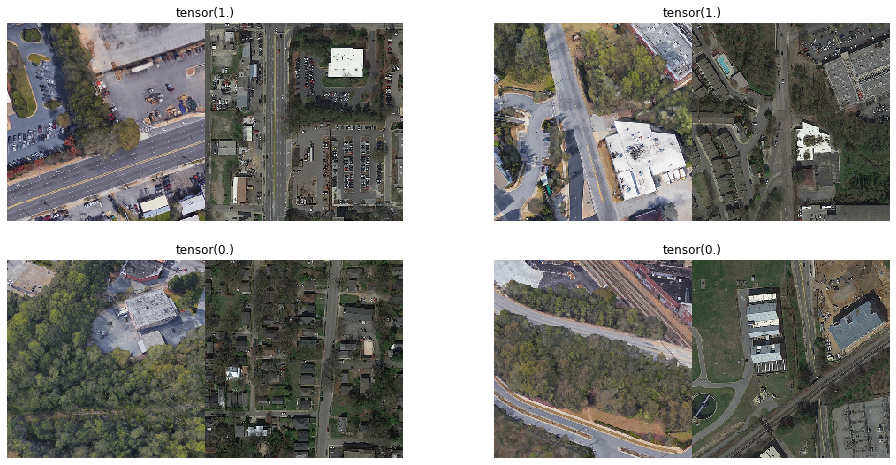

In [7]:
show_ex(train_ds,rows=2, shuffle=True)

In [8]:
bs = 24
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)
data = DataBunch(train_dl, valid_dl)

In [9]:
GEres18 = models.resnet18(pretrained = False) # resnets are initialized with kaiming_normal
GMres18 = models.resnet18(pretrained = False)
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x
GEres18.fc = Identity()
GMres18.fc = Identity()

class DualResnet18(nn.Module):
    def __init__(self):
        super(DualResnet18, self).__init__()
        self.GE = GEres18
        self.GM = GMres18
    def forward(self, img1, img2):
        o1 = self.GE(img1)
        o2 = self.GM(img2)
        output = torch.norm(o1-o2, p=2, dim=1)
        return output

arch = DualResnet18()
arch = arch.to('cuda')

### Contrastive Loss Function 

In [10]:
def loss_contrastive(euclidean_distance, label_batch):
    margin = 100
    loss = torch.mean( (label_batch) * torch.pow(euclidean_distance, 2) +
                    (1-label_batch) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    return loss

## Get, Set, GO Train!!!

In [11]:
learn = Learner(data, arch, loss_func=loss_contrastive)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


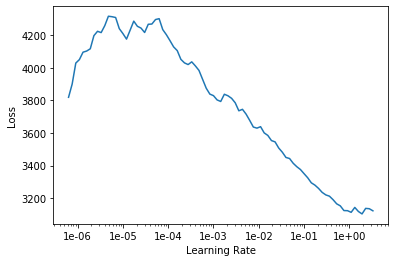

In [12]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(30, max_lr=.1)

epoch,train_loss,valid_loss,time
0,2142.121582,3649.373291,12:26
1,1864.816406,1962.498413,12:22
2,1886.638306,1873.004272,12:17
3,1726.578369,1752.086670,12:15
4,1842.875732,2568.129395,12:17
5,1828.074585,7771.638672,12:16
6,1785.604004,5057.758789,12:17
7,1790.572998,9467.000977,12:17
8,1791.810303,2007.066406,12:03
9,1752.972046,1869.013794,12:00


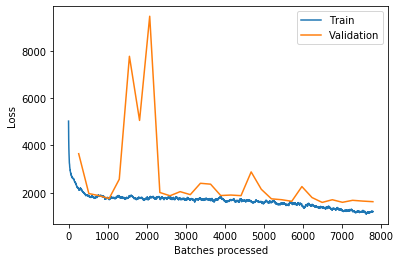

In [17]:
learn.recorder.plot_losses()

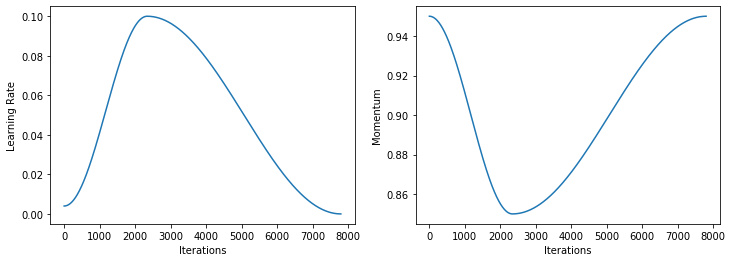

In [18]:
learn.recorder.plot_lr(show_moms=True)

In [19]:
learn.save('09_dual_res_kaiming')